## Food Classification Using Transfer Learning (MobileNetV2)
This notebook implements a **Convolutional Neural Network (CNN)** using **transfer learning** with the **MobileNetV2** backbone for the classification of food images into predefined grades.  

The model takes **RGB images** of food items from the Nutrition5K dataset, leverages pretrained **ImageNet** weights to extract rich visual features, and fine-tunes the network for multi-class food classification.  

**Class imbalance** is addressed using balanced sampling during training, **data augmentation** is applied to improve generalization, and performance is evaluated on both a **"testing" set** for hyperparameter tuning and validation, and a set of **unseen images** to test the model's real-world robustness. Note: Traditionally in ML, this is sometimes called training, validation, and testing, but here I use "train", "test", and "unseen" to avoid confusion.

## Dataset Overview
- **Image Type:** Overhead **RGB images** of food items presented on white plates.
- **Classes:** Each image belongs to one of 7 food-grade categories (`A`, `A+`, `B`, `B+`, `C`, `D`, `F`).
- **Preprocessing:**  
  - Images are resized to `(128, 128)` for consistency and computational efficiency.
  - Pixel values are normalized to a range of `[0, 1]`.
  - **Data augmentation** techniques such as random flips, rotations, zooms, and translations are applied to improve model robustness.
- **Balanced Sampling:** Ensures each mini-batch has an equal representation of all classes to address the dataset's imbalance.
- **Labels:** Labels are one-hot encoded for multi-class classification using categorical cross-entropy as the loss function.

## Objectives
1. **Data Preprocessing & Augmentation:**  
   - Normalize and augment images to reduce overfitting.
   - Use balanced sampling for fair class representation.  

2. **Model Implementation (Transfer Learning):**     
    - **Pretrained Backbone:** MobileNetV2 pretrained on ImageNet for feature extraction.
    - **Input Layer:** Accepts RGB images resized to (IMG_HEIGHT, IMG_WIDTH, 3).
    - **Feature Extractor:** Convolutional layers from MobileNetV2 remain frozen during Phase 1 to retain pretrained weights.
    - **Custom Classification Head:**  
     - **Global Average Pooling:** Reduces spatial dimensions of feature maps through conversion to a single vector.  
     - **Dense Layer (256 units, ReLU):** Fully connected dense layer with ReLU activation learns high-level features.  
     - **Dropout layer (rate=0.35):** For regularization, seeks to mitigate overfitting.  
     - **Output layer:** 7-unit softmax layer for grade probabilities.

3. **Training Strategy:**       
     - **Phase 1:** Train only the custom head while keeping the pretrained layers frozen.
     - **Phase 2:** Unfreeze last 40 layers of MobileNetV2 and fine-tune the entire network with a lower learning rate.
     - **Optimizer:** Adam optimizer (learning rates: 1e-3 for Phase 1, 3e-4 for Phase 2).  
     - **Loss Function:** Categorical cross-entropy.

4. **Model Evaluation:**  
   - Overall accuracy on Test and Unseen datasets.  
   - Per-class accuracy and confusion matrices for detailed insights.  
   - Visualization of predictions on sample images including those misclassified, to understand model limitations
      
## Challenges & Design Choices
- **Class Imbalance:** Balanced sampling ensures each mini-batch covers all classes uniformly.  
- **Small Dataset Size:** Data augmentation and transfer learning mitigate overfitting risks.  
- **Efficiency vs. Accuracy Trade-off:** MobileNetV2 offers a lightweight yet high-performing backbone for real-world deployment.  

## 1. Importing Libraries
All necessary libraries for deep learning, data preprocessing, evaluation, and visualization are imported. This ensures reproducibility and clarity in the workflow.

In [2]:
from pathlib import Path
import glob, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# fix randomness for model comparisons
tf.random.set_seed(42)

## 2. Configuration and Paths
All configuration parameters, including paths to datasets, image dimensions, training hyperparameters, and class labels are defined. Centralizing settings here makes the workflow modular and easier to adjust later.

In [ ]:
BASE_DIR = Path(".").resolve()        # repo folder (includes data, preprocessing, classification)
print("Project root found:", BASE_DIR)

SPLIT_DIR = BASE_DIR / "split"
TRAIN_DIR = SPLIT_DIR / "train"
TEST_DIR = SPLIT_DIR / "test"
UNSEEN_DIR = SPLIT_DIR / "unseen"

IMG_SIZE = (128, 128)       # resized image dimensions
BATCH_SIZE = 70             # samples per batch
STEPS_PER_EPOCH = 409       # ensures full dataset coverage each epoch
EPOCHS_PHASE1 = 30          # early stopping will likely halt sooner
PATIENCE_PHASE1 = 5         # wait 5 epochs without improvement before stopping
EPOCHS_PHASE2 = 7
CLASS_ORDER = ['A', 'A+', 'B', 'B+', 'C', 'D', 'F']  # fixed label order


## 3. Utility Functions and Dataset Creation with Balanced Sampling
Utility functions streamline repetitive tasks such as listing images with labels to keep the main training script clean and readable. Helpers here are used across multiple stages (data loading, balancing, augmenting). Balanced class sampling is crucial because this dataset is class-imbalanced — some grades appear far more frequently than others.

In [15]:
def list_images_with_labels(base_dir, class_order):
    paths, labels = [], []
    for cls in class_order:
        cls_dir = f"{base_dir}/{cls}"
        if not tf.io.gfile.isdir(cls_dir):
            continue
        for ext in "*.jpg", "*.JPG":
            for p in glob.glob(os.path.join(cls_dir, ext)):
                paths.append(p)
                labels.append(class_order.index(cls))
    return np.array(paths), np.array(labels, dtype=np.int32)

AUTOTUNE = tf.data.AUTOTUNE

def make_decoder(img_size):
    def _decode(path):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, img_size)
        return img
    return _decode

def make_augmenter():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1)                       
    ])

def make_base_dataset(paths, labels, img_size, training):
    decode = make_decoder(img_size)
    aug = make_augmenter()

    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((ds_paths, ds_labels))

    def _map(path, y):
        img = decode(path)
        if training:
            img = aug(img, training=True)
        y_onehot = tf.one_hot(y, depth=len(CLASS_ORDER), dtype=tf.float32)
        return img, y_onehot

    if training:
        ds = ds.shuffle(10000, reshuffle_each_iteration=True).repeat()

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    return ds

def make_balanced_train_dataset(paths, labels, img_size):
    ds_all = []
    for c in range(len(CLASS_ORDER)):
        mask = (labels == c)
        p_c = paths[mask]
        y_c = labels[mask]
        if len(p_c) == 0:
            continue
        ds_c = make_base_dataset(p_c, y_c, img_size, training=True)
        ds_all.append(ds_c)
    weights = [1.0/len(ds_all)] * len(ds_all)
    balanced = tf.data.Dataset.sample_from_datasets(ds_all, weights)
    balanced = balanced.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return balanced

def make_eval_dataset(paths, labels, img_size):
    ds = make_base_dataset(paths, labels, img_size, training=False)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

def make_predict_dataset(paths, img_size):
    decode = make_decoder(img_size)
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(lambda p: decode(p), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

## 4. Dataset Summary & Visualization
This section summarizes the number of images per class across the training, test, and unseen datasets. A table reports both the raw counts and class percentages within each split to verify data balance before model training.

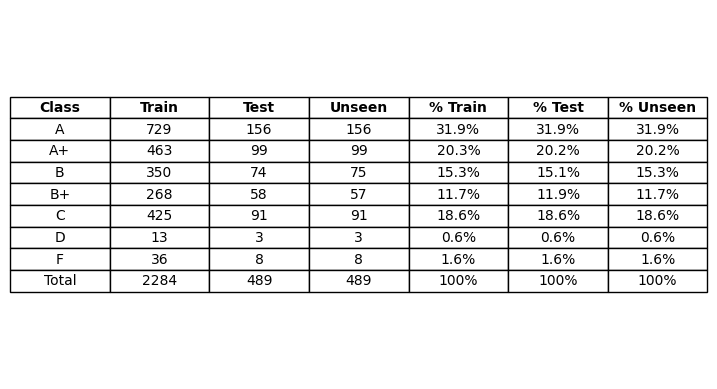

In [16]:
train_paths, train_labels = list_images_with_labels(TRAIN_DIR, CLASS_ORDER)
test_paths,  test_labels  = list_images_with_labels(TEST_DIR, CLASS_ORDER)
unseen_paths, unseen_labels = list_images_with_labels(UNSEEN_DIR, CLASS_ORDER)

def counts_percent_table(train_lbls, test_lbls, unseen_lbls, class_order):
    total_train = len(train_lbls)
    total_test = len(test_lbls)
    total_unseen = len(unseen_lbls)

    rows = []
    for i, cls in enumerate(class_order):
        train_count = int((train_lbls == i).sum())
        test_count = int((test_lbls == i).sum())
        unseen_count = int((unseen_lbls == i).sum())

        rows.append([
            cls,
            train_count,
            test_count,
            unseen_count,
            f"{(train_count / total_train * 100):.1f}%" if total_train > 0 else "0%",
            f"{(test_count / total_test * 100):.1f}%" if total_test > 0 else "0%",
            f"{(unseen_count / total_unseen * 100):.1f}%" if total_unseen > 0 else "0%"
        ])

    # Add totals row
    rows.append([
        "Total",
        total_train,
        total_test,
        total_unseen,
        "100%", "100%", "100%"
    ])

    df = pd.DataFrame(
        rows,
        columns=["Class", "Train", "Test", "Unseen", "% Train", "% Test", "% Unseen"]
    )
    return df

# === Create Table ===
df_counts = counts_percent_table(train_labels, test_labels, unseen_labels, CLASS_ORDER)

# === Image ===
fig, ax = plt.subplots(figsize=(9, 0.6 * len(df_counts)))
ax.axis('off')
table = ax.table(
    cellText=df_counts.values,
    colLabels=df_counts.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.3)

# Bold header row
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

# Save as PNG
plt.savefig("counts_summary_table.png", dpi=200, bbox_inches='tight')
plt.show()

## 5. Data Pipeline Construction
Here, TensorFlow `tf.data` pipelines are built for the training, testing, and unseen datasets.  

- **Training pipeline:** Uses balanced sampling and data augmentation.  
- **Testing & unseen pipelines:** Deterministic (no augmentation) to ensure reproducible evaluation and inference.

In [ ]:
# Build tf.data pipelines using your earlier utility functions
train_ds       = make_balanced_train_dataset(train_paths, train_labels, IMG_SIZE) # for augmenting, repeating etc
test_ds         = make_eval_dataset(test_paths, test_labels, IMG_SIZE) # for early stopping, validation curves etc

# Predict sets (no augmentation/shuffle) for final metrics
train_pred_ds   = make_predict_dataset(train_paths, IMG_SIZE)
test_pred_ds    = make_predict_dataset(test_paths, IMG_SIZE)
unseen_pred_ds  = make_predict_dataset(unseen_paths, IMG_SIZE)

# Function to select one sample per class for visualization
def select_diverse_samples(paths, labels, class_order):
    sample_paths = []
    for i, cls in enumerate(class_order):
        cls_paths = paths[labels == i]
        cls_paths = [p for p in cls_paths if os.path.isfile(p)]  # keep only real files
        if len(cls_paths) > 0:
            sample_paths.append(random.choice(cls_paths))
    return sample_paths

# Select one per class for each dataset
sample_train  = select_diverse_samples(train_paths,  train_labels,  CLASS_ORDER)
sample_test   = select_diverse_samples(test_paths,   test_labels,   CLASS_ORDER)
sample_unseen = select_diverse_samples(unseen_paths, unseen_labels, CLASS_ORDER)

#Visual sanity-check of augmentation (for training set only)
decode = make_decoder(IMG_SIZE)
aug = make_augmenter()

fig, axes = plt.subplots(2, len(sample_train), figsize=(12, 5))
fig.suptitle("Original vs Augmented Training Images", fontsize=14)

for i, path in enumerate(sample_train):
    # Load original image
    img_orig = decode(path).numpy()

    # Apply augmentation (simulate pipeline)
    img_aug  = aug(tf.expand_dims(img_orig, 0), training=True)[0].numpy() 
    
    # Clip to [0,1] so matplotlib stops complaining
    img_orig = np.clip(img_orig, 0, 1)
    img_aug = np.clip(img_aug, 0, 1)

    # Show original on top row
    axes[0, i].imshow(img_orig)
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Show augmented on bottom row
    axes[1, i].imshow(img_aug)
    axes[1, i].set_title("Augmented")
    axes[1, i].axis("off")

# Download preview image

# NOTE: This takes up about 1.5 MB, so keeping the output shown initially increased the size of this file significantly.
        # For this reason, the output is currently saved along with all other output in the "Results" folder.

plt.tight_layout()
plt.savefig("augmented_sample_preview.png", dpi=200, bbox_inches="tight")
plt.show()

## 6. Model Architecture: Transfer Learning with MobileNetV2 
The feature extractor below is built from MobileNetV2 pretrained on ImageNet. A small classification head is added on top, keeping initial layers frozen to leverage learned features while avoiding overfitting on this small dataset.

In [18]:
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base = MobileNetV2(include_top=False, weights="imagenet",
                   input_tensor=inputs,input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False # Phase 1: "freeze backbone"

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(len(CLASS_ORDER), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## 7. Phase 1 Training: Top Layers Only
First, only the classification head is trained while keeping the backbone frozen. Early stopping prevents overfitting, and learning rate reduction adapts training speed based on testing set accuracy (for hyperparameter tuning).


In [19]:
ckpt_path = "best_classification.keras"
cbs_phase1 = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, mode="max", min_delta=0.002, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=PATIENCE_PHASE1, min_delta=0.002, restore_best_weights=True, mode="max", verbose=1)
]

# Phase 1 training
print("=== Phase 1: Train top ===")
history1 = model.fit(
    train_ds, validation_data=test_ds,
    steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_PHASE1,
    callbacks=cbs_phase1, verbose=2
)

# Print final testing (validation) accuracy for Phase 1
best_epoch_phase1 = np.argmax(history1.history['val_accuracy']) + 1
best_test_acc_phase1 = history1.history['val_accuracy'][best_epoch_phase1-1] * 100
print(f"Phase 1 best epoch: {best_epoch_phase1}, Testing Accuracy: {best_test_acc_phase1:.2f}%")

=== Phase 1: Train top ===
Epoch 1/30

Epoch 1: val_accuracy improved from None to 0.47239, saving model to best_classification.keras
409/409 - 71s - 173ms/step - accuracy: 0.5905 - loss: 1.0818 - val_accuracy: 0.4724 - val_loss: 1.3676 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.47239
409/409 - 70s - 170ms/step - accuracy: 0.6876 - loss: 0.7996 - val_accuracy: 0.4458 - val_loss: 1.4774 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.47239

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
409/409 - 68s - 165ms/step - accuracy: 0.7273 - loss: 0.6971 - val_accuracy: 0.4397 - val_loss: 1.5070 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy improved from 0.47239 to 0.47648, saving model to best_classification.keras
409/409 - 66s - 160ms/step - accuracy: 0.7666 - loss: 0.6015 - val_accuracy: 0.4765 - val_loss: 1.4922 - learning_rate: 5.0000e-04
Epoch 5/30

Epoch 5: val_accu

## 8. Phase 2 Training: Fine-tuning Backbone (& Phase 1/Phase 2 Visualization)
After the top layers converge, the last 40 layers of MobileNetV2 are unfrozen for fine-tuning, allowing the pretrained weights to adapt slightly to the domain. Overlay visualization for Phase 1 and Phase 2 demonstrate accuracy and loss.

=== Phase 2: Fine-tune (validate on test) ===
Epoch 1/7
409/409 - 100s - 244ms/step - accuracy: 0.7829 - loss: 0.5897 - val_accuracy: 0.4990 - val_loss: 1.6804 - learning_rate: 3.0000e-04
Epoch 2/7
409/409 - 95s - 233ms/step - accuracy: 0.8960 - loss: 0.2767 - val_accuracy: 0.3681 - val_loss: 3.3741 - learning_rate: 3.0000e-04
Epoch 3/7

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
409/409 - 92s - 224ms/step - accuracy: 0.9360 - loss: 0.1766 - val_accuracy: 0.4499 - val_loss: 3.2309 - learning_rate: 3.0000e-04
Epoch 4/7
409/409 - 90s - 220ms/step - accuracy: 0.9712 - loss: 0.0830 - val_accuracy: 0.5174 - val_loss: 2.5796 - learning_rate: 1.5000e-04
Epoch 5/7
409/409 - 91s - 222ms/step - accuracy: 0.9794 - loss: 0.0626 - val_accuracy: 0.5706 - val_loss: 2.3499 - learning_rate: 1.5000e-04
Epoch 6/7
409/409 - 93s - 227ms/step - accuracy: 0.9818 - loss: 0.0515 - val_accuracy: 0.5399 - val_loss: 2.8009 - learning_rate: 1.5000e-04
Epoch 7/7
409/409 - 91s - 223m

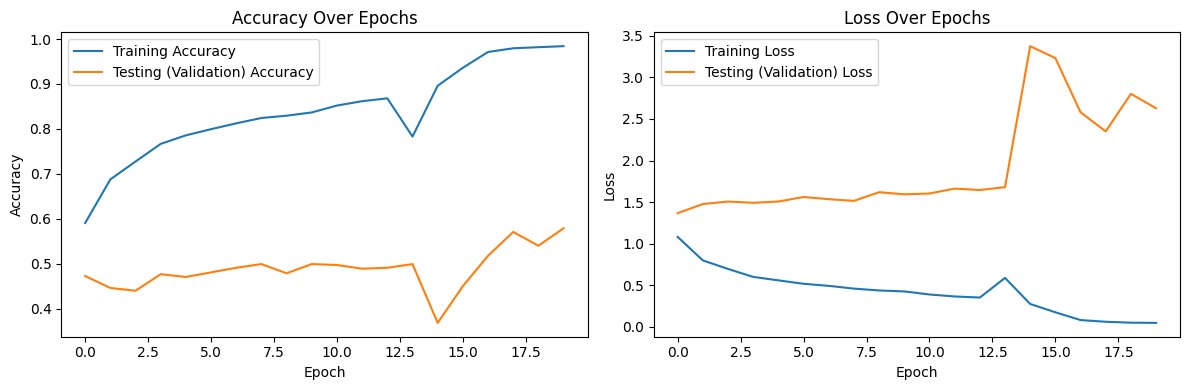

In [20]:
base.trainable = True
for layer in base.layers[:-40]: # Unfreeze only last 40 layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),  # smaller learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cbs_phase2 = [
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, mode="max", verbose=1)
]

print("=== Phase 2: Fine-tune (validate on test) ===")
history2 = model.fit(
    train_ds, validation_data=test_ds,
    steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_PHASE2,
    callbacks=cbs_phase2, verbose=2
)

# Print final test (validation) accuracy for Phase 2
best_epoch_phase2 = np.argmax(history2.history['val_accuracy']) + 1
best_test_acc_phase2 = history2.history['val_accuracy'][best_epoch_phase2-1] * 100
print(f"Phase 2 best epoch: {best_epoch_phase2}, Testing Accuracy: {best_test_acc_phase2:.2f}%")

# === Overlay Plot for Phase 1 & Phase 2 ===
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Combine histories
acc_all = history1.history['accuracy'] + history2.history['accuracy']
test_acc_all = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss_all = history1.history['loss'] + history2.history['loss']
test_loss_all = history1.history['val_loss'] + history2.history['val_loss']

# Accuracy Plot
axs[0].plot(acc_all, label='Training Accuracy')
axs[0].plot(test_acc_all, label='Testing (Validation) Accuracy')
axs[0].set_title('Accuracy Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss Plot
axs[1].plot(loss_all, label='Training Loss')
axs[1].plot(test_loss_all, label='Testing (Validation) Loss')
axs[1].set_title('Loss Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# 9. Model Predictions on Sample Images
This section evaluates the trained model on a fixed set of sample training images that were used earlier for augmentation previews.
By using the exact same images, this provides:

- A direct visual comparison of true vs. predicted labels.
- A quick qualitative check on how well the model generalizes.
- The ability to save results both as a PNG visualization and a DataFrame for error analysis.

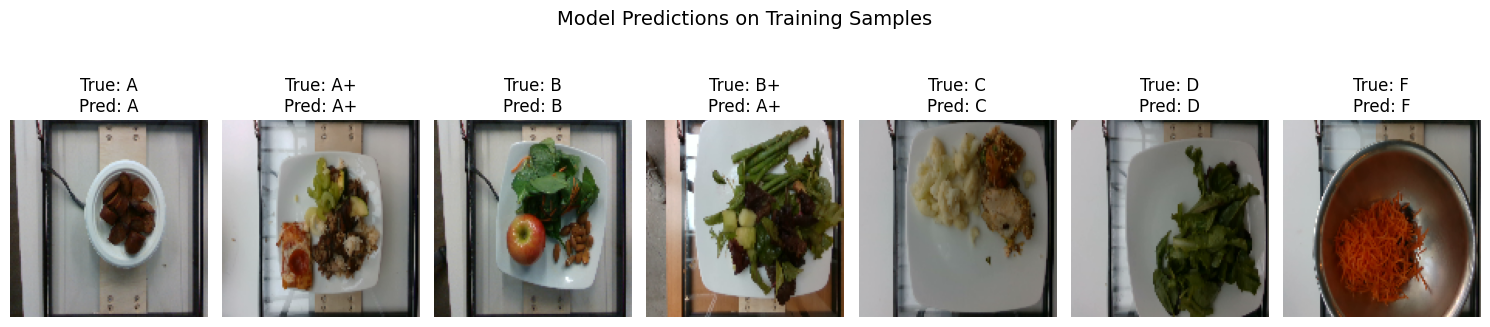

In [22]:
def evaluate_on_preview_images(model, sample_paths, class_order, img_size, title_prefix, save_prefix):
    decode = make_decoder(img_size)
    images = []
    true_labels = []

    # Load images + true labels
    for path in sample_paths:
        img = decode(path).numpy()
        images.append(img)

        # Extract true label from path folder name
        label_name = os.path.basename(os.path.dirname(path))
        true_labels.append(label_name)

    images = np.stack(images, axis=0)
    images = tf.convert_to_tensor(images, dtype=tf.float32)  # ensures consistent type

    # Predict on these images
    probs = model.predict(images, verbose=0)
    preds = probs.argmax(axis=1)
    pred_labels = [class_order[i] for i in preds]

    # Visualization: show images with true vs predicted labels
    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))
    fig.suptitle(f"Model Predictions on {title_prefix} Samples", fontsize=14)

    for i, ax in enumerate(axes):
        ax.imshow(np.clip(images[i], 0, 1))
        ax.set_title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_sample_predictions.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Return predictions for further analysis if needed
    return pd.DataFrame({
        "filename": [os.path.basename(p) for p in sample_paths],
        "true_label": true_labels,
        "pred_label": pred_labels
    })


# Preview sample predictions on training set
df_sample_train_preds  = evaluate_on_preview_images(model, sample_train,  CLASS_ORDER, IMG_SIZE, "Training", "train")

## 10. Evaluate using Testing (tuning) Set
Overall accuracy is computed on the test set, predictions are saved to CSV for error analysis, and visualizations are generated, including training/validation loss, accuracy, and the confusion matrix.


=== Evaluate on TEST (tuning) set ===
Saved: classification_test_results.csv, Overall test (validation) accuracy = 57.87%


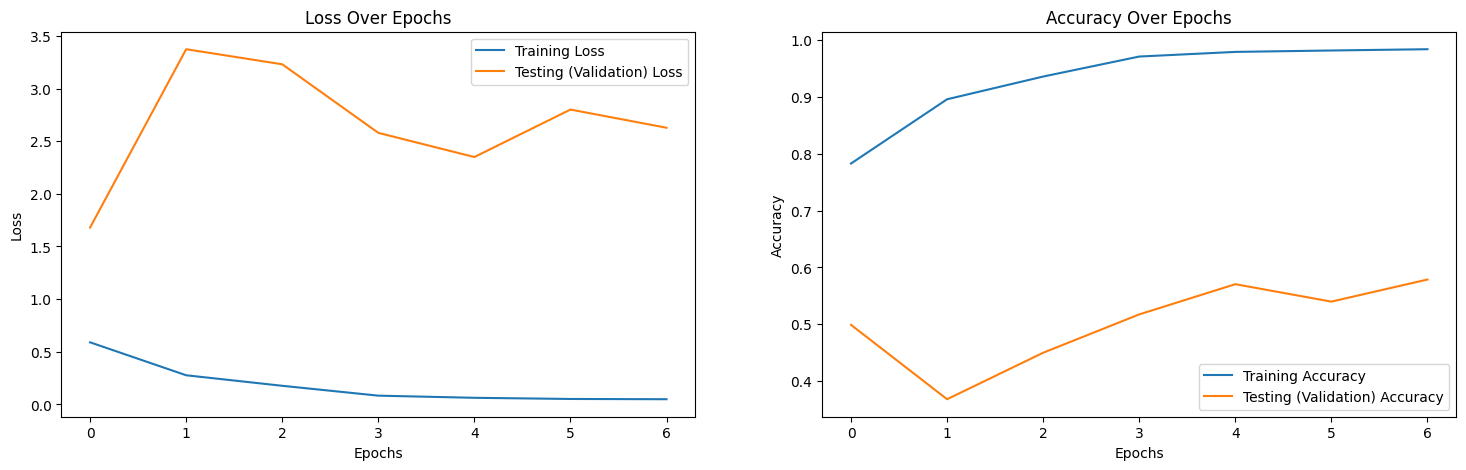

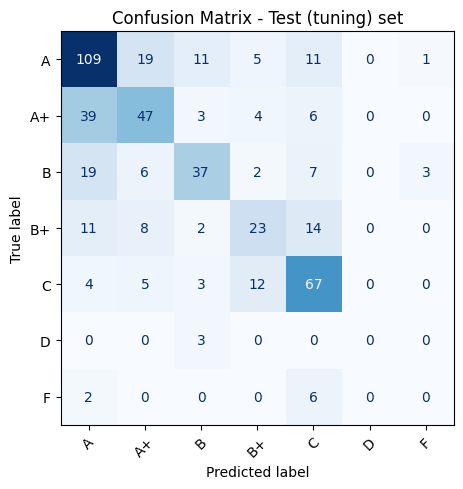

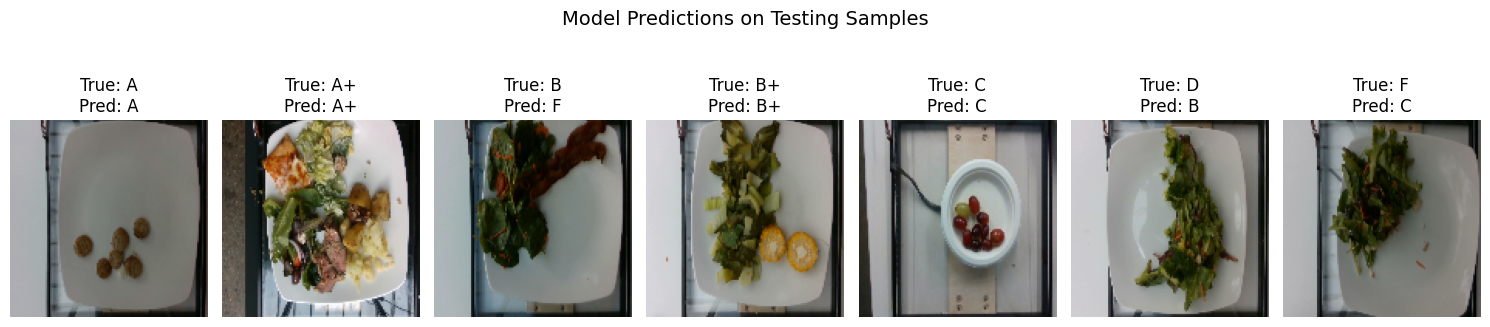

In [23]:
print("=== Evaluate on TEST (tuning) set ===")
test_pred_probs = model.predict(test_pred_ds, verbose=0)
test_preds = test_pred_probs.argmax(axis=1)
test_true_labels = test_labels
test_acc = accuracy_score(test_true_labels, test_preds)

# Save test results
test_rows = []
for p, tid, pid in zip(test_paths, test_true_labels, test_preds):
    test_rows.append({"filename": os.path.basename(p),
                      "true_grade": CLASS_ORDER[tid],
                      "pred_grade": CLASS_ORDER[pid]})
test_df = pd.DataFrame(test_rows)
test_df.to_csv("classification_test_results.csv", index=False)
print(f"Saved: classification_test_results.csv, Overall test (validation) accuracy = {test_acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_preds, labels=range(len(CLASS_ORDER)))

# Create and save confusion matrix visual
fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_ORDER)
disp.plot(cmap="Blues", ax=ax_cm, colorbar=False, xticks_rotation=45)
ax_cm.set_title("Confusion Matrix - Test (tuning) set")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=150)

# Preview sample predictions on TEST set
df_sample_test_preds   = evaluate_on_preview_images(model, sample_test,   CLASS_ORDER, IMG_SIZE, "Testing", "test")

# Note: Please disregard plots below. They should disappear when the code is re-run. The full plots can be found under the Phase 2 section.

## 11. Predict on Unseen Data
Finally, predictions for unseen images are generated to simulate real-world deployment and results are once again saved for further review. Three images from the unseen set are also randomly sampled and their grades are predicted using the trained model. These are displayed for qualitative evaluation.

=== Predict on UNSEEN ===
Saved: classification_unseen_results.csv, Overall unseen accuracy = 56.65%
No images found in the unseen folder.


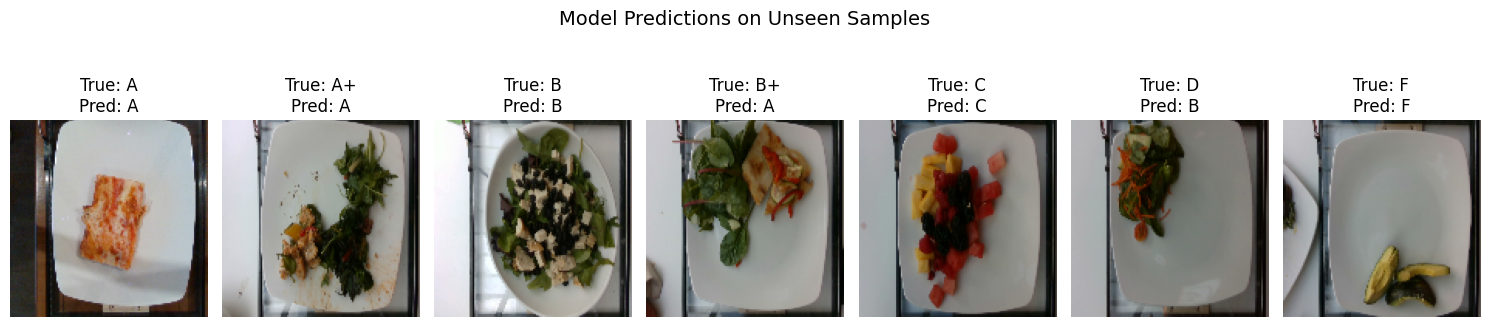

In [24]:
print("=== Predict on UNSEEN ===")
unseen_pred_probs = model.predict(unseen_pred_ds, verbose=0)
unseen_preds = unseen_pred_probs.argmax(axis=1)
unseen_true_labels = unseen_labels
unseen_acc = accuracy_score(unseen_true_labels, unseen_preds)

unseen_rows = []
for p, pid, tid in zip(unseen_paths, unseen_true_labels, unseen_labels):
    unseen_rows.append({"filename": os.path.basename(p),
                        "true_grade": CLASS_ORDER[tid],
                        "pred_grade": CLASS_ORDER[pid]})
    
unseen_df = pd.DataFrame(unseen_rows)
unseen_df.to_csv("classification_unseen_results.csv", index=False)
print(f"Saved: classification_unseen_results.csv, Overall unseen accuracy = {unseen_acc*100:.2f}%")

def load_and_preprocess_images(folder_path, img_height, img_width, sample_size=3):
    images, image_files = [], []
    all_files = glob.glob(os.path.join(folder_path, "*.jpg"))
    if not all_files:
        return np.array([]), []

    sample_files = np.random.choice(all_files, min(sample_size, len(all_files)), replace=False)
    for img_file in sample_files:
        img = load_img(img_file, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        image_files.append(img_file)

    return np.array(images), image_files

# Load 3 sample unseen images
unseen_images, sample_files = load_and_preprocess_images(UNSEEN_DIR, IMG_SIZE[0], IMG_SIZE[1])

if unseen_images.size > 0:
    predictions = model.predict(unseen_images)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_grades = [CLASS_ORDER[i] for i in predicted_classes]

    # Show images with predictions
    plt.figure(figsize=(12, 4))
    for i, (img, grade) in enumerate(zip(unseen_images, predicted_grades)):
        plt.subplot(1, len(unseen_images), i+1)
        plt.imshow(img)
        plt.title(f"Pred: {grade}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No images found in the unseen folder.")

# Preview sample predictions on UNSEEN set
df_sample_unseen_preds = evaluate_on_preview_images(model, sample_unseen, CLASS_ORDER, IMG_SIZE, "Unseen",   "unseen")

## Section 12: Final Summary & Metrics
Model performance is summarized by reporting:
- Training accuracy on the final epoch
- Overall accuracy on the Test (tuning) and Unseen (held out) datasets
- Per-class accuracy for each grade


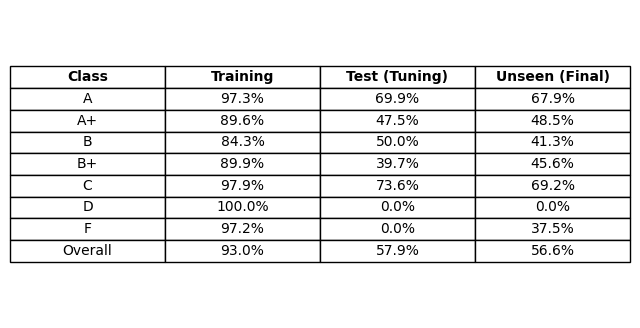

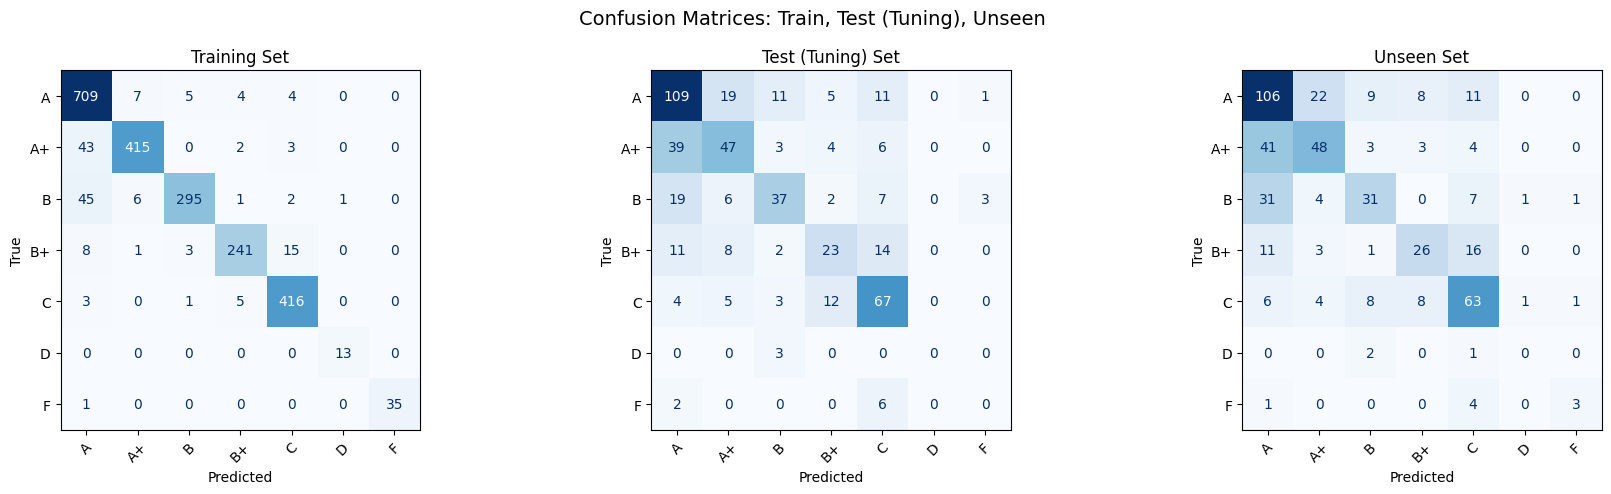

In [25]:
# Build a non-augmented, non-repeated version of the training set for evaluation
train_eval_ds = make_eval_dataset(train_paths, train_labels, IMG_SIZE)  # no augmentation, no repeat

# Predict on training set
train_probs  = model.predict(train_eval_ds, verbose=0)
train_preds  = train_probs.argmax(axis=1)
train_true_labels   = train_labels  # original ground truth labels
train_acc = accuracy_score(train_true_labels, train_preds)

# === Overall Accuracy Percents ===
train_acc_pct = train_acc * 100
test_acc_pct = test_acc * 100
unseen_acc_pct = unseen_acc * 100

# === Per-Class Accuracy ===
cm_train    = confusion_matrix(train_true_labels, train_preds, labels=range(len(CLASS_ORDER)))
cm_test   = confusion_matrix(test_true_labels, test_preds, labels=range(len(CLASS_ORDER)))
cm_unseen = confusion_matrix(unseen_true_labels, unseen_preds, labels=range(len(CLASS_ORDER)))

per_class_acc_train    = (cm_train.diagonal()    / cm_train.sum(axis=1).clip(min=1)) * 100
per_class_acc_test   = (cm_test.diagonal()   / cm_test.sum(axis=1).clip(min=1)) * 100
per_class_acc_unseen = (cm_unseen.diagonal() / cm_unseen.sum(axis=1).clip(min=1)) * 100

# === Create Table ===
rows = []
for i, cls in enumerate(CLASS_ORDER):
    rows.append([
        cls,
        f"{per_class_acc_train[i]:.1f}%",
        f"{per_class_acc_test[i]:.1f}%",
        f"{per_class_acc_unseen[i]:.1f}%"
    ])

# True Overall Accuracies
rows.append([
    "Overall",
    f"{train_acc_pct:.1f}%",
    f"{test_acc_pct:.1f}%",
    f"{unseen_acc_pct:.1f}%"
])

df_acc_summary = pd.DataFrame(rows, columns=["Class","Training", "Test (Tuning)", "Unseen (Final)"])

# === Plot Table ===
fig, ax = plt.subplots(figsize=(8, 0.5 * len(df_acc_summary)))
ax.axis('off')
tbl = ax.table(
    cellText=df_acc_summary.values,
    colLabels=df_acc_summary.columns,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)

# Bold header row
for key, cell in tbl.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

plt.savefig("accuracy_summary_table.png", dpi=200, bbox_inches='tight')
plt.show()

# === Print Summary to Console ===
# print("\n=== Final Accuracy Summary ===")
# print(df_acc_summary.to_string(index=False))

# Final Confusion Matrices for all three sets
def plot_confusion_matrices(train_true_labels, train_preds, test_true_labels, test_preds, unseen_true_labels, unseen_preds, class_order):

    sets = [
        ("Training", train_true_labels, train_preds),
        ("Test (Tuning)", test_true_labels, test_preds),
        ("Unseen", unseen_true_labels, unseen_preds)
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("Confusion Matrices: Train, Test (Tuning), Unseen", fontsize=14)

    for ax, (title, y_true, y_pred) in zip(axes, sets):
        cm = confusion_matrix(y_true, y_pred, labels=range(len(class_order)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_order)
        disp.plot(cmap="Blues", ax=ax, colorbar=False, xticks_rotation=45)
        ax.set_title(f"{title} Set")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.savefig("confusion_matrices_all_sets.png", dpi=200, bbox_inches="tight")
    plt.show()

# === Usage ===
plot_confusion_matrices(
    train_true_labels, train_preds,
    test_true_labels, test_preds,
    unseen_true_labels, unseen_preds,
    CLASS_ORDER
)